# Extended Bipole over a halfspace

Compare the analytic solution (empymod) with the numerical solutions calculated using SimPEG. We look at solution on a cylindrical mesh. This can be used to test mesh design for casing simulations

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
import time
from string import ascii_lowercase
import os

# empymod
import empymod

# SimPEG, discretize
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg.utils.solver_utils import get_default_solver

# from SimPEG.electromagnetics import time_domain as tdem
from simpeg import utils, maps, Report

from matplotlib import rcParams
rcParams["font.size"] = 12


In [2]:
from casing_utils import plot_slice

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.mumps.Mumps

In [4]:
Report()

--------------------------------------------------------------------------------
  Date: Tue Apr 15 22:22:50 2025 PDT

                OS : Darwin (macOS 13.7.4)
            CPU(s) : 12
           Machine : arm64
      Architecture : 64bit
               RAM : 64.0 GiB
       Environment : Jupyter
       File system : apfs

  Python 3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:18:52)
  [Clang 18.1.8 ]

            simpeg : 0.23.0
        discretize : 0.11.2
       pymatsolver : 0.3.1
             numpy : 2.2.4
             scipy : 1.15.2
        matplotlib : 3.10.1
            geoana : 0.7.2
            libdlf : 0.3.0
             numba : 0.61.2
           IPython : 9.1.0
        ipywidgets : 8.1.6
--------------------------------------------------------------------------------

In [5]:
domain_x = 1000
domain_z = 1000

In [6]:
# mesh parameters

csx = 10 # P_casing_t/3.  # min cell size in x
csz = 10          # z cell size (m)

pf = 1.3          # growth factor for cells in the pad zones 
npadx = 14          # number of pad cells after domain_max_x where growth is by pf factor
npadz = 14        # number of z pad cells above and below

hx = discretize.utils.unpack_widths([
    (csx, int(np.ceil(domain_x/csx)) + 4), (csx, npadx, pf)
])

# Theta discretization
ny = 12
hy = np.ones(ny)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = 1.2*domain_z/csz 
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
cyl_mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print('Number of cells',cyl_mesh.n_cells)

Number of cells 209568


PolarAxes


[<PolarAxes: >, <Axes: xlabel='x', ylabel='z'>]

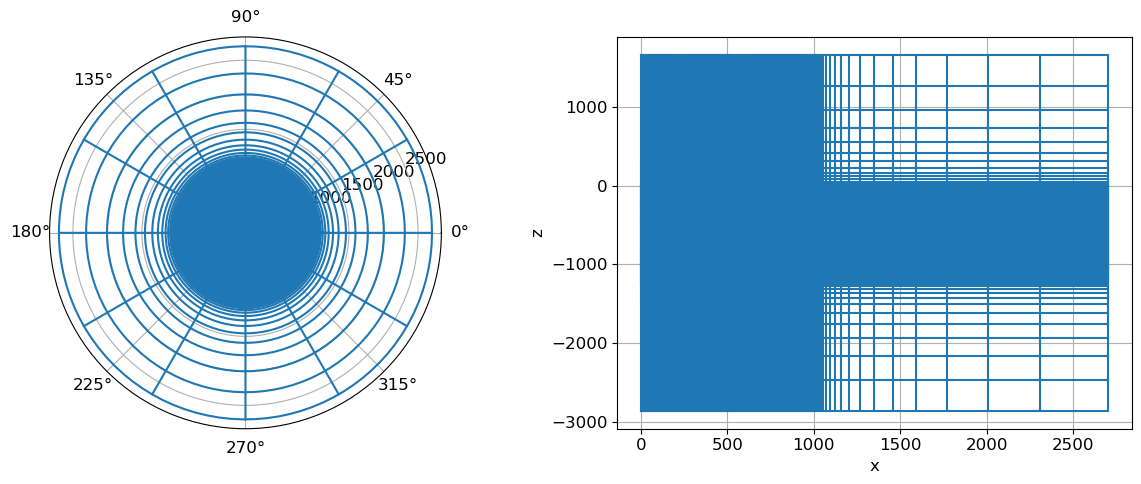

In [7]:
cyl_mesh.plot_grid()

## specify source location, survey geometry

In [8]:
src_x = np.r_[0, 300] 
src_z = -csz/2

In [9]:
src_theta = cyl_mesh.h[1][0]/2

src_a = np.r_[src_x[0], src_theta, src_z] 
src_b = np.r_[src_x[1], src_theta, src_z]

In [10]:
rx_x_extent = np.r_[2, 1000]
rx_x = cyl_mesh.nodes_x[(cyl_mesh.nodes_x > rx_x_extent[0]) & (cyl_mesh.nodes_x < rx_x_extent[1])]
rx_x

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
       120., 130., 140., 150., 160., 170., 180., 190., 200., 210., 220.,
       230., 240., 250., 260., 270., 280., 290., 300., 310., 320., 330.,
       340., 350., 360., 370., 380., 390., 400., 410., 420., 430., 440.,
       450., 460., 470., 480., 490., 500., 510., 520., 530., 540., 550.,
       560., 570., 580., 590., 600., 610., 620., 630., 640., 650., 660.,
       670., 680., 690., 700., 710., 720., 730., 740., 750., 760., 770.,
       780., 790., 800., 810., 820., 830., 840., 850., 860., 870., 880.,
       890., 900., 910., 920., 930., 940., 950., 960., 970., 980., 990.])

In [11]:
rx_theta = src_theta + np.pi/2 
rx_z = -csz/2

PolarAxes


(0.0, 2000.0)

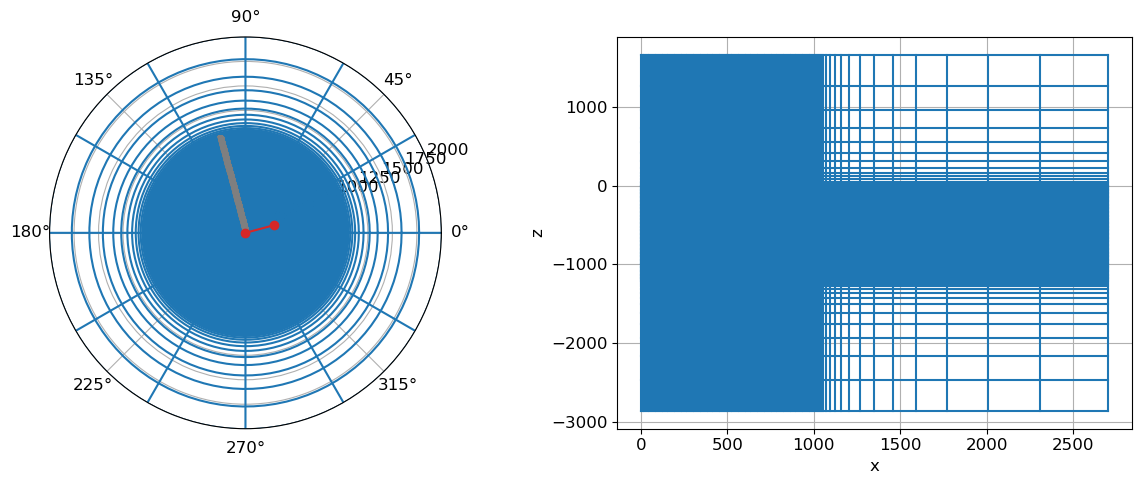

In [12]:
ax = cyl_mesh.plot_grid()

ax[0].plot(rx_theta * np.ones_like(rx_x), rx_x, "C7v", ms=4)
ax[0].plot([src_a[1], src_b[1]], [src_a[0], src_b[0]], "-C3o")
ax[0].set_rlim(0, 2000)

# set up SimPEG simulation

In [13]:
freq = 1
sig_air = 1e-4
sig_halfspace = 1

In [14]:
500/np.sqrt(sig_halfspace * freq)

np.float64(500.0)

In [15]:
src_locations = np.vstack([src_a, src_b])
receiver_locations = discretize.utils.ndgrid([rx_x, rx_theta, rx_z])

In [16]:
src_locations

array([[ 0.00000000e+00,  2.61799388e-01, -5.00000000e+00],
       [ 3.00000000e+02,  2.61799388e-01, -5.00000000e+00]])

In [17]:
rx_real = fdem.Rx.PointElectricField(locations=receiver_locations, orientation='x', component="real")
rx_imag = fdem.Rx.PointElectricField(locations=receiver_locations, orientation='x', component="imag")

rx_list = [rx_real, rx_imag]

In [18]:
src = fdem.sources.LineCurrent(frequency=freq, location=src_locations, receiver_list=rx_list)

survey = fdem.Survey([src])

In [19]:
sim = fdem.simulation.Simulation3DCurrentDensity(
    mesh=cyl_mesh, sigmaMap=maps.IdentityMap(cyl_mesh),
    survey=survey, solver=utils.solver_utils.get_default_solver(),
    verbose=True, forward_only=True
)

In [20]:
sigma_model = sig_halfspace * np.ones(cyl_mesh.n_cells)
sigma_model[cyl_mesh.cell_centers[:, 2] > 0] = sig_air

(<matplotlib.collections.QuadMesh at 0x2865be850>,
 <Axes: xlabel='x', ylabel='z'>,
 <matplotlib.colorbar.Colorbar at 0x286564050>)

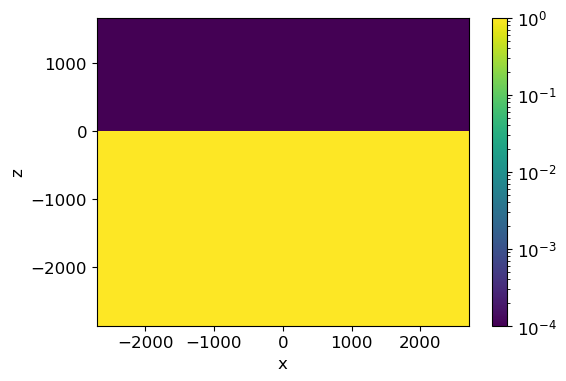

In [21]:
plot_slice(
    cyl_mesh, sigma_model, pcolor_opts={"norm":LogNorm()},
)

In [22]:
%%time
fields = sim.fields(sigma_model)
data = sim.make_synthetic_data(sigma_model, f=fields) 

/Users/lindseyjh/miniforge3/envs/2025-casing-demo/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


CPU times: user 4min 42s, sys: 20 s, total: 5min 2s
Wall time: 1min 7s


## analytic solution with empymod

In [23]:
# General input
inputs = {
    'src': [src_a[0], src_b[0], 0, 0, 0, 0],
    'srcpts': 100,  # Bipole 
    'rec': [np.zeros_like(rx_x), rx_x, -rx_z, 90, 0],
    'depth': [0],
    'freqtime': freq,                 # 1 Hz
    'strength': 1,
    # 'aniso': aniso,
    # 'htarg': {'pts_per_dec': -1},  # Faster computation
    # 'verb': 2,                     # Verbosity
}

data_empymod = empymod.bipole(res=[1/sig_air, 1/sig_halfspace], **inputs)
# data_empymod /= (src_b[0] - src_a[0])


:: empymod END; runtime = 0:00:00.473061 :: 100 kernel call(s)



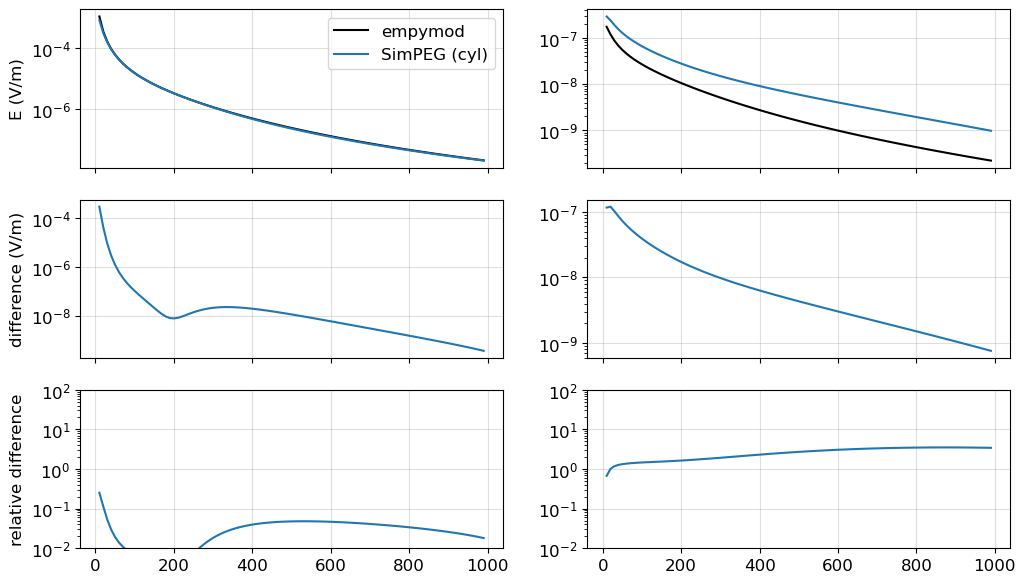

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(12, 7), sharex=True)

ax[0, 0].semilogy(rx_x, np.abs(data_empymod.real), label="empymod", color="k")
ax[0, 0].semilogy(rx_x, np.abs(data[src, rx_real]), label="SimPEG (cyl)", color="C0")

ax[1, 0].semilogy(rx_x, np.abs(np.abs(data_empymod.real)-np.abs(data[src, rx_real])), label="difference (cyl)", color="C0")

ax[2, 0].semilogy(rx_x, np.abs(np.abs(data_empymod.real)-np.abs(data[src, rx_real]))/np.abs(data_empymod.real), label="difference (cyl)", color="C0" )


ax[0, 1].semilogy(rx_x, np.abs(data_empymod.imag), label="empymod", color="k")
ax[0, 1].semilogy(rx_x, np.abs(data[src, rx_imag]), label="SimPEG (cyl)", color="C0")

ax[1, 1].semilogy(rx_x, np.abs(np.abs(data_empymod.imag)-np.abs(data[src, rx_imag])), label="difference (cyl)", color="C0")

ax[2, 1].semilogy(rx_x, np.abs(np.abs(data_empymod.imag)-np.abs(data[src, rx_imag]))/np.abs(data_empymod.imag), label="difference (cyl)", color="C0")

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("relative difference")
    
for a in ax.flatten():
    a.grid(alpha=0.4)
ax[0, 0].legend()

for a in ax[2, :].flatten():
    a.set_ylim([1e-2, 1e2])